In [40]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import re

results_path="/home/jkipen/ProtInfGPU/results/5_Prot/"

# Running experiments with oracle on 152Prot


In [32]:
#Parameters we will tune
n_epochs=60;
subset=500000;
oracle_err=0;
cv_runs=10;

In [33]:
opt_prot_inf="./../code/cuda/opt.out" 
in_path= "/home/jkipen/raid_storage/ProtInfGPU/data/153_Prot/binary/rf_n_est_10_depth_10"
out_path= "/home/jkipen/ProtInfGPU/results/153_Prot/Oracle"
base_command= opt_prot_inf + " " + in_path + " " +out_path 
command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);

In [34]:
print(command)
os.system(command)


./../code/cuda/opt.out /home/jkipen/raid_storage/ProtInfGPU/data/153_Prot/binary/rf_n_est_10_depth_10 /home/jkipen/ProtInfGPU/results/153_Prot/Oracle -d 3 -e 60 -c 10 -m 50 -M 30 -s 500000 -t 128 -o 0


0

In [35]:
oracle_errs=[0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]
for oracle_err in oracle_errs:
    base_command= opt_prot_inf + " " + in_path + " " +out_path 
    command= base_command + " -d 3 -e "+str(n_epochs) +" -c "+str(cv_runs)+" -m 50 -M 30 -s "+str(subset)+" -t 128 -o "+str(oracle_err);
    os.system(command)

## Comparing oracles with diff errors

In [45]:
def ret_config(config_path, key):
    with open(config_path, "r") as file:
        for line in file:
            if line.startswith(key + ":"):
                return line.split(":")[1].strip()  # Get the value after ':' and remove spaces
    return None  # Return None if the key is not found
def get_data_from_experiment(exp_path):
    df=pd.read_csv(exp_path+'/ErrVsEpochs.csv')
    df_numpy=df.to_numpy()
    x=df_numpy[:,0]; y=df_numpy[:,1];  y_err=df_numpy[:,2]/2
    p_err=ret_config(exp_path+"/RunConfig.txt","Oracle Perr")
    return x,y,y_err,p_err

In [58]:
n_dists=100;n_prot=152; ##Get what is the worst error (equidistributed guess)
exponential_vars = np.random.exponential(size=(n_dists, n_prot))
random_dists = exponential_vars / exponential_vars.sum(axis=1, keepdims=True)
equidis_err = np.mean(np.mean(np.abs(random_dists-np.ones(shape=(n_dists,n_prot))/n_prot),axis=1))

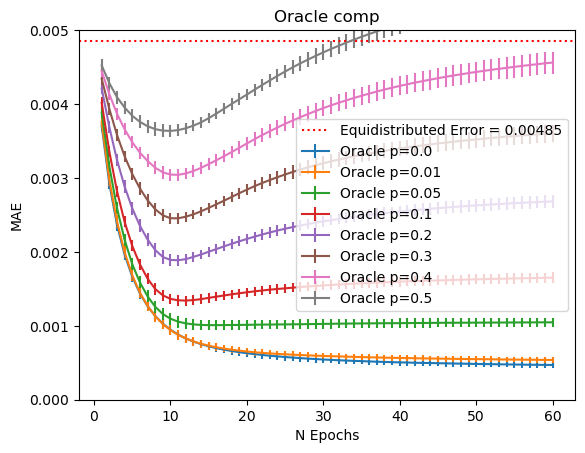

In [59]:
plt.figure()
plt.ylabel("MAE")
plt.xlabel("N Epochs")
xs=[];ys=[];y_errs=[];p_errs=[];
with os.scandir(out_path) as entries:
    for entry in entries:
        if entry.is_dir() and re.match(r"^\d", entry.name):  # Only consider directories that starts with numbers
            x,y,y_err,p_err=get_data_from_experiment(os.path.join(out_path, entry.name))
            xs.append(x);ys.append(y);y_errs.append(y_err);p_errs.append(float(p_err));
            #plt.errorbar(x, y,  yerr=y_err, label= "Oracle p=" + p_err)
            
sorted_data = sorted(zip(p_errs, xs, ys, y_errs), key=lambda t: t[0])  
p_errs, xs, ys, y_errs = zip(*sorted_data)  # Unpack sorted data

for x, y, y_err, p_err in zip(xs, ys, y_errs, p_errs):
    plt.errorbar(x, y, yerr=y_err, label=f"Oracle p={p_err}")

plt.axhline(y=equidis_err, color='red', linestyle='dotted', label=f'Equidistributed Error = {equidis_err:.5f}')
    
plt.legend()
plt.title("Oracle comp")
plt.ylim([0, 0.005])
plt.show()

In [56]:
print(equidis_err)

0.00478593406916323
